In [16]:
import os
import tensorflow as tf
import yaml
import matplotlib.pyplot as plt


# Définir les chemins des dossiers d'entraînement et de test
train_dir = 'C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Training'  # Remplacez par le chemin réel du dossier d'entraînement
test_dir = "C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Testing"         # Remplacez par le chemin réel du dossier de test

def renommer_images(dossier_principal):
    # Pour chaque catégorie (glioma, meningioma, etc.) dans le dossier principal
    for categorie in os.listdir(dossier_principal):
        chemin_categorie = os.path.join(dossier_principal, categorie)
        
        # Vérifier que c'est bien un dossier
        if os.path.isdir(chemin_categorie):
            # Parcourir les fichiers dans le dossier de catégorie
            for index, nom_fichier in enumerate(os.listdir(chemin_categorie), start=1):
                # Construire le nouveau nom de fichier avec le format "categorie_index.extension"
                extension = os.path.splitext(nom_fichier)[1]
                nouveau_nom = f"{categorie}_{index}{extension}"
                
                # Obtenir les chemins complets des fichiers d'origine et de destination
                chemin_ancien = os.path.join(chemin_categorie, nom_fichier)
                chemin_nouveau = os.path.join(chemin_categorie, nouveau_nom)
                
                # Renommer le fichier
                os.rename(chemin_ancien, chemin_nouveau)
                print(f"Renommé: {chemin_ancien} --> {chemin_nouveau}")

# Appliquer la fonction aux dossiers d'entraînement et de test
renommer_images(train_dir)
renommer_images(test_dir)


Renommé: C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Training\glioma_tumor\glioma_tumor_1.jpg --> C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Training\glioma_tumor\glioma_tumor_1.jpg


FileExistsError: [WinError 183] Impossible de créer un fichier déjà existant: 'C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Training\\glioma_tumor\\glioma_tumor_10.jpg' -> 'C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/data/Training\\glioma_tumor\\glioma_tumor_2.jpg'

In [8]:
import tensorflow as tf
import yaml

# Charger les paramètres de prétraitement
with open('C:/Users/ouaha/OneDrive/Bureau/projet app stat/archive/config.yml', 'r') as file:
    params = yaml.safe_load(file)

preprocessing_params = params['preprocessing']
target_size = tuple(preprocessing_params['target_size'])
normalize = preprocessing_params['normalize']
standardize = preprocessing_params['standardize']
grayscale = preprocessing_params['grayscale']


In [9]:
def load_and_preprocess_image(path):
    # Charger l'image
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1 if grayscale else 3)  # Convertir en niveaux de gris si spécifié
    img = tf.image.resize(img, target_size)  # Redimensionner l'image

    if normalize:
        img = img / 255.0  # Normaliser entre 0 et 1

    if standardize:
        img = (img - tf.reduce_mean(img)) / tf.math.reduce_std(img)  # Standardisation

    return img

def prepare_dataset(directory):
    images = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                images.append(load_and_preprocess_image(img_path))
                labels.append(label)  # ou utiliser un encodage d'étiquettes

    return tf.data.Dataset.from_tensor_slices((images, labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7353925..5.7537127].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.756385..4.301124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1577119..3.1042643].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.843829..4.1983013].


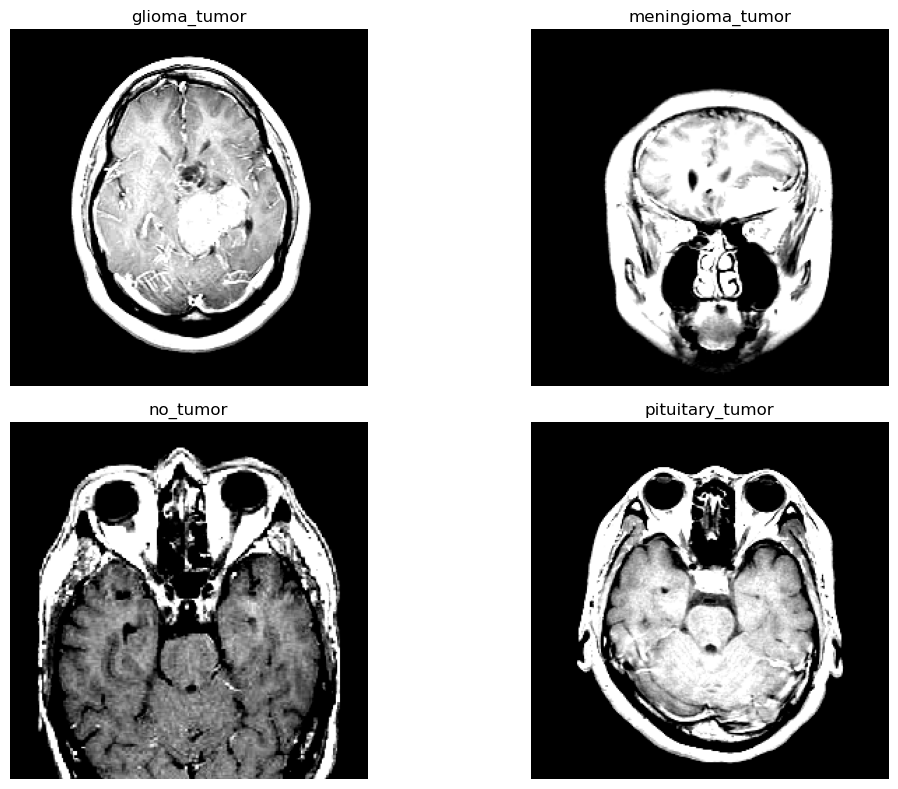

In [10]:
import matplotlib.pyplot as plt


# Préparer les ensembles de données
train_dataset = prepare_dataset(train_dir)
test_dataset = prepare_dataset(test_dir)

# Initialiser un ensemble vide pour suivre les labels déjà affichés
displayed_labels = set()

# Afficher la première image de chaque label
plt.figure(figsize=(12, 8))
num_images = 0

for img_tensor, label in train_dataset:
    label_str = label.numpy().decode('utf-8')  # Convertir le label en chaîne

    # Vérifiez si le label a déjà été affiché
    if label_str not in displayed_labels and num_images < 4:
        plt.subplot(2, 2, num_images + 1)  # Créer un subplot pour chaque image
        plt.imshow(img_tensor.numpy())  # Afficher l'image
        plt.title(label_str)  # Titre avec le label
        plt.axis('off')  # Pas d'axes
        displayed_labels.add(label_str)  # Marquer le label comme affiché
        num_images += 1  # Incrémenter le compteur d'images

    # Sortir de la boucle si 4 images ont été affichées
    if num_images >= 4:
        break

plt.tight_layout()  # Ajuster les sous-figures
plt.show()  # Afficher toutes les images

In [11]:
len(test_dataset)
len(train_dataset)

2870

In [12]:
full_dataset = train_dataset.shuffle(buffer_size=2000)

# Définir le pourcentage pour la validation
validation_split = 0.2  # 10% pour la validation
num_samples = tf.data.experimental.cardinality(full_dataset).numpy()  # Nombre total d'échantillons
num_validation = int(num_samples * validation_split)  # Nombre d'échantillons pour la validation

# Créer les ensembles d'entraînement et de validation
val_dataset = full_dataset.take(num_validation)  # Prendre les premiers num_validation échantillons
train_dataset = full_dataset.skip(num_validation)  # Sauter ces échantillons pour l'ensemble d'entraînement

print(f'Taille de l\'ensemble d\'entraînement : {tf.data.experimental.cardinality(train_dataset).numpy()}')
print(f'Taille de l\'ensemble de validation : {tf.data.experimental.cardinality(val_dataset).numpy()}')

Taille de l'ensemble d'entraînement : 2296
Taille de l'ensemble de validation : 574


In [13]:
labels_seen = set()

for image, label in val_dataset:
    label_decoded = label.numpy().decode('utf-8')
    labels_seen.add(label_decoded)

print("Labels présents dans l'ensemble de validation :", labels_seen)

Labels présents dans l'ensemble de validation : {'glioma_tumor', 'no_tumor', 'pituitary_tumor', 'meningioma_tumor'}


In [17]:
def save_to_tfrecord(dataset, filename):
    writer = tf.io.TFRecordWriter(filename)  # Créer un writer pour le fichier TFRecord
    count=0
    for image, label in dataset:
        # Vérification et ajustement de la forme de l'image
        if image.shape[-1] == 1:  # Si l'image est en niveaux de gris
            image = tf.image.grayscale_to_rgb(image)  # Convertir en RGB
        image = tf.image.resize(image, target_size)  # Redimensionner si nécessaire
        
        # Encoder l'image au format JPEG
        image_bytes = tf.io.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()

        # Convertir le label en bytes seulement s'il n'est pas déjà en bytes
        if isinstance(label, tf.Tensor):
            label_bytes = label.numpy().decode('utf-8').encode('utf-8')  # Convertir de tensor à bytes
        else:
            label_bytes = label  # Si le label est déjà en bytes, l'utiliser directement
        
        # Créer un dictionnaire de caractéristiques
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes])),
            'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label_bytes]))
        }
        
        # Créer un exemple TFRecord
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())
        count += 1

    writer.close()  # Fermer le writer
    return count


save_to_tfrecord(train_dataset, 'train_data.tfrecord')
save_to_tfrecord(val_dataset, 'val_data.tfrecord')
save_to_tfrecord(test_dataset, 'test_data.tfrecord')


394

In [18]:
len(test_dataset)
len(train_dataset)

2296

In [ ]:
# Optionnel : appliquer des transformations supplémentaires, comme le mélange et le lot
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32)
test_dataset = test_dataset.batch(32)
val_dataset=val_dataset.batch(32)